# GEDI L4A Subsetting Example

## [Optional] Install Python Packages

This notebook contains some cells marked as optional, meaning that you can use this notebook without necessarily running such cells.

However, if you do wish to run the optional cells, you must install the following Python packages, which might not already be installed in your environment:

- `geopandas`: for reading your AOI (GeoJson file), as well as for reading the job output (GeoPackage file containing the subset)
- `contextily`: for visually verifying your AOI
- `backoff`: for repeatedly polling the job status (after submission) until the job has been completed (either successfully or not)
- `folium`: for visualizing your data on a Leaflet map
- `geojsoncontour`: for converting your matplotlib contour plots to geojson

In [1]:
# Uncomment the following lines to install these packages if you haven't already.
# !pip install geopandas
# !pip install contextily
# !pip install backoff
# !pip install folium
# !pip install geojsoncontour

A job can be submitted without these packages, but installing them in order to run the optional cells may make it more convenient for you to visually verify both your AOI and the subset output produced by your job.

## Obtain Username

In [2]:
from maap.maap import MAAP

maap = MAAP(maap_host="api.ops.maap-project.org")
username = maap.profile.account_info()["username"]
username

'sayers'

## Define the Area of Interest

You may use either a publicly available GeoJSON file for your AOI, such as
those available at [geoBoundaries](https://www.geoboundaries.org), or you
may create a custom GeoJSON file for your AOI.  The following 2 subsections
cover both cases.

### Using a geoBoundary GeoJSON File

If your AOI is a publicly available geoBoundary, you can obtain the URL for the
GeoJSON file using the function below.  You simply need to supply an ISO3 value
and a level.  To find the appropriate ISO3 and level values, see the
[table on the geoBoundaries site](https://www.geoboundaries.org/index.html#getdata).

In [3]:
import requests


def get_geo_boundary_url(iso3: str, level: int) -> str:
    response = requests.get(
        f"https://www.geoboundaries.org/api/current/gbOpen/{iso3}/ADM{level}"
    )
    response.raise_for_status()
    return response.json()["gjDownloadURL"]


# If using a geoBoundary, uncomment the following assignment, supply
# appropriate values for `<iso3>` and `<level>`, then run this cell.

# Example (Gabon level 0): get_geo_boundary("GAB", 0)

# aoi = get_geo_boundary_url("<iso3>", <level>)

### Using a Custom GeoJSON File

Alternatively, you can make your own GeoJSON file for your AOI and place it
within your `my-public-bucket` folder within the ADE.

Based upon where you place your GeoJSON file under `my-public-bucket`, you can
construct the URL for a job's `aoi` input value.

For example, if the relative path of your AOI GeoJSON file under
`my-public-bucket` is `path/to/my-aoi.geojson` (avoid using whitespace in the
path and filename), the URL you would supply as the value of a job's `aoi`
input would be the following (where `{username}` is replaced with your username
as output from the previous section):

```
f"https://maap-ops-workspace.s3.amazonaws.com/shared/{username}/path/to/my-aoi.geojson"`
```

If this is the case, use the cell below.

In [4]:
#aoi = f"https://maap-ops-workspace.s3.amazonaws.com/shared/{username}/langtang_np.geojson"

#for your convenience you can use this geoJSON file but if you have your own geojson, use the commented link as example format
aoi = f"https://maap-ops-workspace.s3.amazonaws.com/shared/anisbhsl/langtang_np.geojson"

This example uses the AOI of Gosaikunda Lake region inside Langtang National Park. You can also create your own GeoJSON file for your AOI using sites like [geojson.io](https://geojson.io/)

![Gosaikunda](../../_static/gedi_l4a_example_lantang_aoi.png)

## [Optional] Visually Verify your AOI

If you want to visually verify your AOI before proceeding, you may run the following cell, if you have the `geopandas` and `contextily` Python packages installed.

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


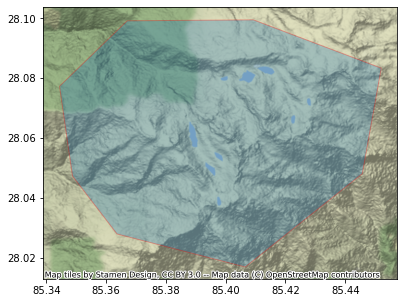

In [5]:
try:
    import geopandas as gpd
    import contextily as ctx
except:
    print(
        "If you wish to visually verify your AOI, "
        "you must install the `geopandas` and `contextily` packages."
    )
else:
    aoi_gdf = gpd.read_file(aoi)
    aoi_epsg4326 = aoi_gdf.to_crs(epsg=4326)
    ax = aoi_epsg4326.plot(figsize=(10, 5), alpha=0.3, edgecolor="red")
    ctx.add_basemap(ax, crs=4326)

## Submit a Job

When supplying input values for a GEDI subsetting job, to use the default value
for a field (where indicated), use a dash (`"-"`) as the input value.

- `aoi` (required): URL to a GeoJSON file representing your area of interest,
  as explained above.

- `doi`: Digital Object Identifier (DOI) of the GEDI collection to subset, or
  a logical name representing such a DOI.  Valid logical names: L1B, L2A,
  L2B, L4A

- `columns`: Comma-separated list of column names to include in the output file.

- `query`: Query expression for subsetting the rows in the output file.

- `limit`: Maximum number of GEDI granule data files to download (among those
  that intersect the specified AOI). (Default: 10000)

It is recommended to use `maap-dps-worker-32gb` queues when submitting a job with a large aoi.

In [6]:
inputs = dict(
   aoi=aoi,
   doi="L4A",
   lat="lat_lowestmode",
   lon="lon_lowestmode",
   beams="all",
   columns="agbd, agbd_se,elev_lowestmode,sensitivity, geolocation/sensitivity_a2",
   query="l2_quality_flag == 1 and l4_quality_flag == 1 and sensitivity > 0.95 and `geolocation/sensitivity_a2` > 0.95",
   limit = 10_000
)

result = maap.submitJob(
    identifier="gedi-subset",
    algo_id="gedi-subset_ubuntu",
    version="develop",
    queue="maap-dps-worker-32gb",
    username=username,
    **inputs,
)

job_id = result["job_id"]
job_id or result

'ead0cec5-8ca5-4d0c-8517-963e0a618894'

## Get the Job's Output File

Now that the job has been submitted, we can use the `job_id` to check the job
status until the job has been completed.

In [7]:
import xml.etree.ElementTree as ET
from urllib.parse import urlparse


def job_status_for(job_id: str) -> str:
    response = maap.getJobStatus(job_id)
    response.raise_for_status()

    root = ET.fromstring(response.text)
    status_element = root.find(".//{http://www.opengis.net/wps/2.0}Status")

    return status_element.text


def job_result_for(job_id: str) -> str:
    response = maap.getJobResult(job_id)
    response.raise_for_status()

    root = ET.fromstring(response.text)

    return root.find(".//{http://www.opengis.net/wps/2.0}Data").text


def to_job_output_dir(job_result_url: str) -> str:
    url_path = urlparse(job_result_url).path
    # The S3 Key is the URL path excluding the `/{username}` prefix
    s3_key = "/".join(url_path.split("/")[2:])

    return f"/projects/my-private-bucket/{s3_key}"

If you have installed the `backoff` Python package, running the following cell
will automatically repeatedly check your job's status until the job has
been completed. Otherwise, you will have to manually repeatedly rerun the following
cell until the output is either `'Succeeded'` or `'Failed'`.

In [8]:
try:
    import backoff
except:
    job_status = job_status_for(job_id)
else:
    # Check job status every 2 minutes
    @backoff.on_predicate(
        backoff.constant,
        lambda status: status not in ["Deleted", "Succeeded", "Failed"],
        interval=120,
    )
    def wait_for_job(job_id: str) -> str:
        return job_status_for(job_id)

    job_status = wait_for_job(job_id)

job_status

INFO:backoff:Backing off wait_for_job(...) for 66.9s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 75.4s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 59.1s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 101.0s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 119.1s (Running)
INFO:backoff:Backing off wait_for_job(...) for 17.2s (Running)
INFO:backoff:Backing off wait_for_job(...) for 80.4s (Running)


'Succeeded'

In [9]:
assert job_status == "Succeeded", (
    job_result_for(job_id)
    if job_status == "Failed"
    else f"Job {job_id} has not yet completed ({job_status}). Rerun the prior cell."
)

output_url = job_result_for(job_id)
output_dir = to_job_output_dir(output_url)
output_file = f"{output_dir}/gedi_subset.gpkg"
print(f"Your subset results are in the file {output_file}")

Your subset results are in the file /projects/my-private-bucket/dps_output/gedi-subset_ubuntu/develop/2022/12/16/20/37/29/132757/gedi_subset.gpkg


## [Optional] Visually Verify the Results

If you installed the `geopandas` Python package, you can visually verify the
output file by running the following cell.

                                            filename  BEAM        agbd  \
0  GEDI04_A_2020347023307_O11328_02_T07169_02_002...  0000  116.018761   
1  GEDI04_A_2020347023307_O11328_02_T07169_02_002...  0000  323.874420   
2  GEDI04_A_2020347023307_O11328_02_T07169_02_002...  0000  295.168396   
3  GEDI04_A_2020347023307_O11328_02_T07169_02_002...  0000  127.484352   
4  GEDI04_A_2020347023307_O11328_02_T07169_02_002...  0000  345.088531   

    agbd_se  elev_lowestmode  sensitivity  geolocation/sensitivity_a2  \
0  7.206294      2612.725342     0.963938                    0.963938   
1  7.232505      2588.142090     0.965968                    0.965968   
2  7.224230      2537.219727     0.969290                    0.969290   
3  7.206897      2534.912842     0.980470                    0.980470   
4  7.240329      2613.810059     0.979566                    0.979566   

                    geometry  
0  POINT (85.35394 28.04128)  
1  POINT (85.35434 28.04165)  
2  POINT (85.35513 28.0

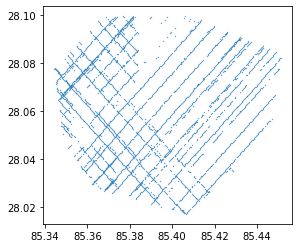

In [10]:
try:
    import geopandas as gpd
    import matplotlib.pyplot as plt
except:
    print(
        "If you wish to visually verify your output file, "
        "you must install the `geopandas` package."
    )
else:
    gedi_gdf = gpd.read_file(output_file)
    print(gedi_gdf.head())
    sensitivity_colors = plt.cm.get_cmap("viridis_r")
    gedi_gdf.plot(markersize = 0.1)

## Generate contour lines
Create a `lat`, `lon` mesh grid with elevation as a depth parameter. As shown in the plot above, the lines don't seem smooth. So we can apply `linear` or 'cubic` interpolation to smoothen those missing points.

In [11]:
geometry = gedi_gdf["geometry"]
elevation=gedi_gdf["elev_lowestmode"]

In [12]:
lon = geometry.x
lat = geometry.y

In [13]:
import numpy as np

x=np.linspace(min(lon), max(lon), 1000)
y=np.linspace(min(lat), max(lat), 1000)

In [14]:
from scipy.interpolate import griddata

x_mesh, y_mesh = np.meshgrid(x,y)

You may experiment with `nearest`, `linear`, and `cubic` interpolation methods to see which gives more smooth results.

In [15]:
#grid the elevation
z_mesh = griddata((lon, lat), elevation, (x_mesh, y_mesh), method='linear')

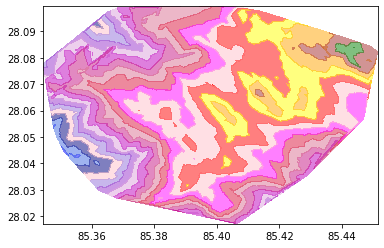

In [16]:
colors=['blue','royalblue', 'navy','pink',  'mediumpurple',  'darkorchid',  'plum',  'm', 'mediumvioletred', 'palevioletred', 'crimson',
         'magenta','pink','red','yellow','orange', 'brown','green', 'darkgreen']
levels=len(colors)
contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5,  colors=colors, linestyles='None', vmin=elevation.min(), vmax=elevation.max())

![ContourPlot](../../_static/gedi_l4a_example_contour_plot.png)

Now we need to plot this contour into an interactive map for better visualization.

## Plot the contour lines in folium
You may need to install `geojsoncontour`, `mapclassify`, and `folium`, if you don't already have them installed.
We need to convert this `contourf` into geoJSON format.

In [17]:
import folium 
from folium import plugins
import branca
import geojsoncontour

In [18]:
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    unit='ft',
    fill_opacity=0.1,
)

In [19]:
#create map view
m = folium.Map([lat.mean(), lon.mean()], zoom_start=12, tiles="OpenStreetMap")

folium.GeoJson(
    geojson,
    style_function=lambda x:{
        'color': x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.5,
    }
).add_to(m)

cm = branca.colormap.LinearColormap(colors, vmin=elevation.min(), vmax=elevation.max()).to_step(levels)
cm.caption='Elevation (in m)'
m.add_child(cm)

#legend
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(m)

In [20]:
m

Now you have an interactive visualization of a contour plot.

![ContourMAP](../../_static/gedi_l4a_example_folium_map.png)